# Data Intelligence Application Project 
### Pricing and Adverticing
#### Aquaro Gabriele, Carratta Francesco, Moroni Fabio, Zanaboni Riccardo
<br/>

## Overview
The project analyzes a common scenario in the pricing and advertising fields. The goal is to maximize the income of an e-commerce, jointly maximizing the pricing and bidding strategies.
The process is divided into experiments, which analyze different degrees of freedom of the variables involved in the maximization problem.


In [2]:
from customerManager import CustomerManager
import matplotlib.pyplot as plt
import numpy as np

from experiments.experiment1 import experiment1run
from experiments.experiment2 import Experiment2
from experiments.experiment3 import Experiment3
from experiments.experiment4 import Experiment4
from experiments.experiment5 import Experiment5
from experiments.experiment6 import Experiment6
from experiments.experiment7 import Experiment7


customer_path = "./config/customer_classes.json"
cManager = CustomerManager(file_path = customer_path)

## Real world scenario
The reference enviroment is a wine e-commerce. The company request is to optimize the cost of the advertising campaign and the price of their new wine based on the customer's characteristics. Speaking about the Advertising environment, we supposed that the auction follows a GSP allocation mechanism and that in the considered bid range there will be a bidder close to our value in every auction.

### User
The identified users classes are defined by characteristics linked to economic resources and the frequency of purchase of wine products. More in detail, we considered both the budget and the loyality as a binary features (High - Low, Frequent - Occasional).
Using the cross product of this two fesatures, we took into cosideration only the users in the interesting subset of classes:

    - Class 0  =  Wealthy and frequent buyer  (High Budget - Frequent)
    - Class 1  =  Wealthy and Occasional  (High Budget - Occasional)
    - Class 2  =  Frequent, but "Smart" (Low Budget - Frequent)
We choosed to exclude from the analysis the class with the worst feature pair, becuase there would be a strong stochastic factor, due to the aleatory nature of an occasional buyer, and the increase of the revene would be very low, due to the low budget.

### Product
We choosed to analyze a wine ecommerce because for its nature, it allows to change the price very rapidly, throught boundles/discountes and it presents a strong periodicity of purchase, because it's a rapidly consumable item.


## Data

### Bid
A bid value for each customer class  bids =  [bid0, bid1, bid2]; The bids are in range from 1 to 10.
### Price
The price to optimize is constrained between 3 and 15.  


### Daily Clicks
We supposed the daily click to be distributed as a logistic function on the bid. The saturation level will depend on the user class:
we expect to receive more clicks from Class 2 users, because they are probably looking for discounts. The class-1 users instead are the one with the lowest saturation level, because they have more budget and can give less consideration to advertising.

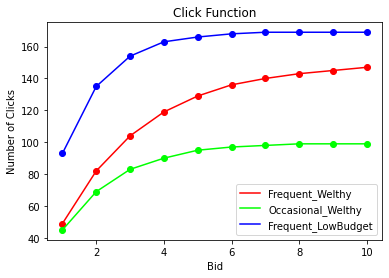

In [2]:
#Data Generation
X = np.arange(1,11)
Y = []
for c in cManager.classes:
    Y.append([])
    for x in X:
        Y[c["class_id"]].append(cManager.clicks(c["class_id"], bid = x, noise = False)) 


#Plotting of click function
plt.figure()
colors = [[1,0,0] , [0,1,0 ], [0,0,1]]
for c in cManager.classes:    
    plt.plot(X, Y[c["class_id"]], color=colors[c["class_id"]], label = c["name"])
    
    plt.scatter(X, Y[c["class_id"]], color=colors[c["class_id"]])
    plt.title("Click Function")
    plt.xlabel("Bid")
    plt.ylabel("Number of Clicks")


plt.legend()
plt.show()

### Cost per click
Due to the limited bid range and GSP hypothesis, we supposed that for each bid there will be a competing advertiser very close to our value.<br>
This will cause the cost per click function to be upper bounded by our bid value. <br> 
Because of this we approximated the cost per click to the bid. (Being strictly pessimistic)

### Conversion rate
**Conversion rates** have been chosen to best represent the willingness of the different types of users to make a purchase as a function of the various price values. <br>
Here we reported some data about a possible semi-realistic distribution. In a real world implementation these values could be obtained from a statistical study on the historical data of the e-commerce (using cookies to classify the users) 

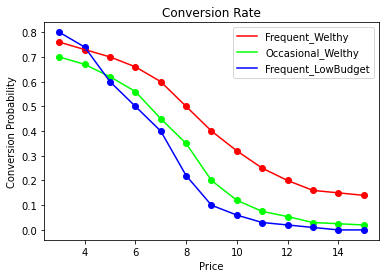

In [3]:
import matplotlib.pyplot as plt
import numpy as np


#Plotting 
plt.figure()
colors = [[1,0,0] , [0,1,0 ], [0,0,1]]
for c in cManager.classes:    
    plt.plot([i[0] for i in c["conversion_rate_matrix"]],
             [i[1] for i in c["conversion_rate_matrix"]], 
             color=colors[c["class_id"]], label = c["name"])
    
    plt.scatter([i[0] for i in c["conversion_rate_matrix"]],
                [i[1] for i in c["conversion_rate_matrix"]],
                color=colors[c["class_id"]])
    plt.title("Conversion Rate")
    plt.xlabel("Price")
    plt.ylabel("Conversion Probability")


plt.legend()
plt.show()

#### Comeback rate
The rappresentation of the **comeback rate** has been supposed to fit a possible distribution of repeated purchases by different classes of users. <br> 
This is distribution is used to compute the expected number of purchases after the first one, for each class of users. <br>
Also this distribution could be easily learned from the historical data.

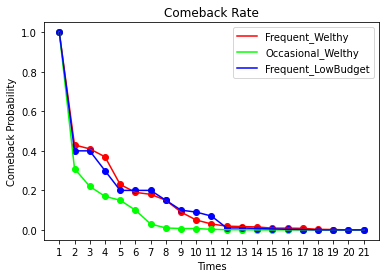

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
colors = [[1,0,0] , [0,1,0 ], [0,0,1]]

X = np.arange(1, 22)
Y = []


#Data Generation
for c in cManager.classes:
    Y.append([])
    for x in X:
        Y[c["class_id"]].append(cManager.comeback_probability(c["class_id"], times = x, noise = False)) 



#Plotting 
for c in cManager.classes:    
    plt.xticks(X)
    plt.plot(X,
             Y[c["class_id"]], 
             color=colors[c["class_id"]], label = c["name"])
    
    plt.scatter(X,
                Y[c["class_id"]], 
                color=colors[c["class_id"]])
    plt.title("Comeback Rate")
    plt.xlabel("Times")
    plt.ylabel("Comeback Probability")


plt.legend()
plt.show()



# Objective Function
Maximizing the revenue, given as the difference between the reward (profit) and the cost per click times the clicks ( costs ). 

It can be expressed as :
### $$ max_{p,b}( \sum \limits_{C_i} (p \times soldItems(b_i, p)) - (clicks(b_i) \times costPerClick(b_i))) $$


with the following constraints:
$$ p >= 3  $$
$$ p <= 15  $$
$$ 0 < b_i < 10  \hspace{5mm} \forall i $$
$$ \sum(costPerClick(b_i)) <= B  $$

where:
- $p$ is the price of the product.
- $b$ is the bid for class *i*.
- $B$ is the daily budget for the advertising campaign.
- $C$ is the set of customer classes.
- $soldItems(b_i, p)$ is the amount of sold item given in input bid and price.
- $clicks(b_i)$ is the amount of click given a bid.
- $costPerClick(b_i)$ is the cost for each click given the bid.

The last constraint is not needed due to the missing of a limited budget in the assignment. 

### 1. Best joint strategy with known parameter

The first step of our work was to evaluate the optimal bidding/pricing pair when all the parameters are known and not noisy. To do so,we used the optimization algorithm minimize in the scipy package. <br>
This algorithm allows to optimize an objective function with possibility of fixing some constraints. <br> 
Here we report the result, that provides the best "bids, price" set with a clairvoyant algorithm. This set has been used in the successive steps to analyse the efficiency of the implemented algorithms.
An empirical analysis of the execution time of the function optimize.minimize (used to evaluate the optimal joint bid/price point) provided almost constant results using 10 bids/price  and 1000 possible values. From this we deduce that the complexity of the algorithm is probably linear in the input range.

In [5]:
experiment1run()

100%|██████████| 50/50 [00:02<00:00, 24.21it/s]

Best method is none with a value of 2408.711107477785
Optimal Solution
bid 1 = 3.862248821187323
bid 2 = 2.182222217620383
bid 3 = 2.3471273752554467
price = 6.319053811953672



### 2. Best joint strategy with known parameter in online enviroment
The goal of this step was to implement an online learning algorithm to correctly learn the best bid/price combination in a noisy environment. <br>
To achieve this goal we implemented a Gaussian Process based learner that at each time steps calculates the best bids/price pair according to the information it has collected. The best pair is so used for a day and then when the outcome is received the gaussian process fits the revenue function adding the new point. <br>
To trade of exploration and exploitation we inserted the possibility of selecting a random bids/price at each time step. The probability of exploration decreases quadratically in time. This allows to converge in a relatively low number of steps. (compared to step 7 when the multiarmed bandit approach is used)  
<br/><br/>
Regrets are calculated using as benchmark the optimal joint bids/price set calculated at Step 1. As we can see in the first exploration phase the regret is pretty high. While when the probability of playing a stochastic combination goes to zero, the algorithm has found the best solution (Regret around 0 + Noise).



### No delay


In [6]:
experiment = Experiment2()
experiment.run()

100%|██████████| 365/365 [06:38<00:00,  1.09s/it]


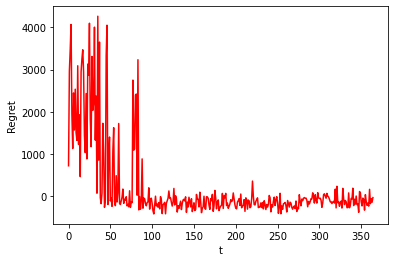

In [7]:
experiment.showRegret()

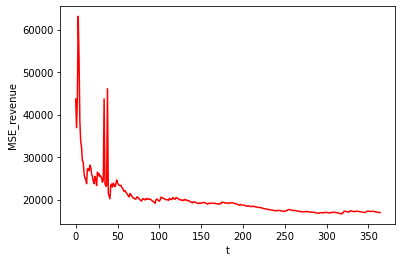

In [8]:
experiment.showMSE()

### Delay

100%|██████████| 365/365 [04:03<00:00,  1.50it/s]


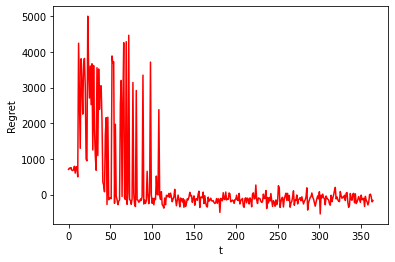

In [9]:
delay = 10
experiment = Experiment2(delay)
experiment.run()
experiment.showRegret()
#experiment.showMSE()

### 3. Best pricing strategy with known parameter , fixed bid and no discrimination among customers in online enviroment
This Experiment tries to compute the optimal price given a fixed set of bids. <br>
In this scenario the algorithm doesn't discriminate among customers classes. <br> 
Here it's implemented both with a TS learner and a UCB1 learner.

#### Thompson Sampling Learner
The TS learner implements a Gaussian Prior with mean equals to the empirical mean at each timestep, while the variance parameter is calculated using a slight variation of the empirical variance that adds a coefficient inversely proportional to the times that the arm has been pulled. <br>
(This because the empirical variance can't be used in Thompson Sampling as it is). <br>
The regret of the algortithm is the theoretical regret of the classical Thompson Sampling Learner. <br> 
The same implementation of this Thompson Sampling Learner is used in the other steps, with the needed adaptation.

#### UCB1 
For the UCB1 learner the random variable of every arm is a Bernoulli in {0, 1} with unknown mean, and each arm has, potentially, a different mean. <br>
Every arm is associated to an upper confidence bound. <br>
At every round, the arm with the highest upper confidence bound is chosen. <br>
Then, after observing the realization of the reward of the arm, the upper confidence bound is updated. 


In [10]:
from experiments.experiment3 import Experiment3
experiment3 = Experiment3()
experiment3.run()

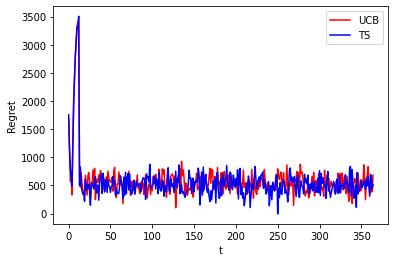

In [11]:
experiment3.showRegret()

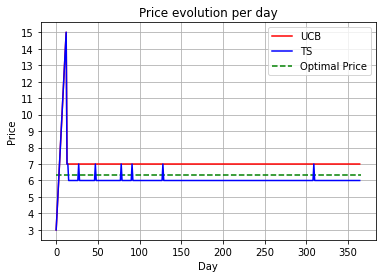

In [12]:
experiment3.showPriceEvolution()

### 4. Best pricing strategy with known parameters, bids are fixed with distinction among customers in online enviroment

The scenario is similar to the one of experiment 3:
- The bids are fixed.
- The number of daily clicks and the daily cost per click are known.

The objective is to find the best pricing strategy for each class.

This experiment includes two different parts:
1. In the first one we perform a pricing strategy for each single class, so without data aggregation.
2. Then combine the classes in groups depending on previous analysis, with partial data aggregation.




In [6]:
experiment4 = Experiment4()
experiment4.run()
experiment4.run_part2()

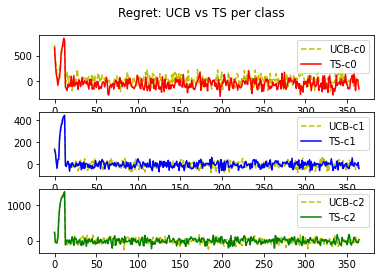

In [7]:
#experiment4.show_UCB_regret_separated_classes()
#experiment4.show_TS_regret_separated_classes()
experiment4.show_UCBvsTS_separeted_classes()

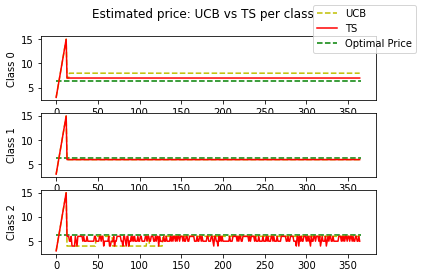

In [8]:
experiment4.show_price_per_class()

### Partial aggregation of classes.

By observing the plots of the regrets and price evolution for each class, we noticed a similar performance for Class-1 and Class-2, so we aggregated the data for these two classes and performed again the algorithm.

As we can see in the following plots, the results remain invariant with no particular detail to highlight.

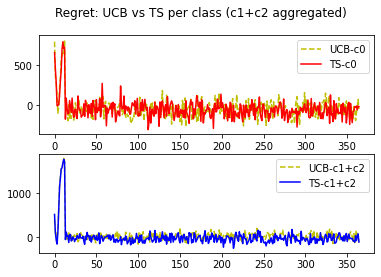

In [9]:
experiment4.show_UCBvsTS_part2()

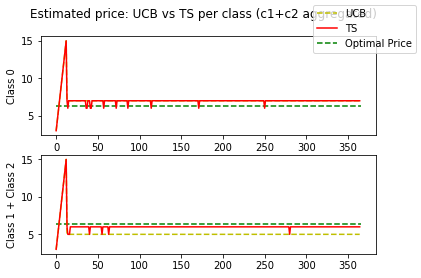

In [10]:
experiment4.estimated_price_part2()

### 5. Best bidding strategy with fixed price, known parameters, no discimination among users and safety constraint in online enviroment.
In this experiment we used Thompson Sampling to learn the best bidding strategy when the price is fixed and the customer information is not known.  <br>
Our implementation of the TS algorithm has an optional attribute to implement a "safety-block" to stop the algorithm from playing losing arms (ones with negative reward).

In order to calculate the probability that the distribution gives a negative value, we used the complementary error function:
$$
\frac{erfc(\frac{\mu}{\sqrt{2}*\sigma})}{2} >= safetyValue
$$
$$
safetyValue=0.2
$$




In [3]:
experiment5 = Experiment5()
experiment5.run()

100%|██████████| 365/365 [00:00<00:00, 1862.20it/s]


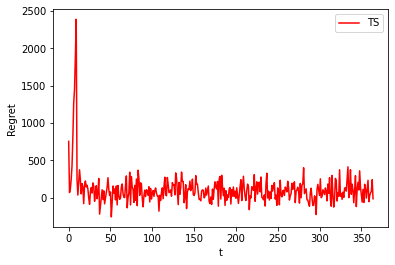

In [4]:
experiment5.showRegret()

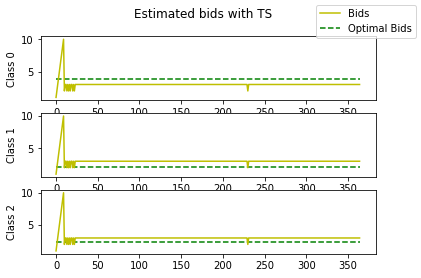

In [5]:
experiment5.show_bids_per_class()

### 6. Best joint strategy with known parameter, no discrimination among customers and safety constraint in online enviroment
Here we  simply adapted the TS learner algorithm to solve the joint problem with aggregated user classes.

In [1]:
from experiments.experiment6 import Experiment6

experiment6 = Experiment6()
experiment6.run()

100%|██████████| 365/365 [00:00<00:00, 1220.62it/s]


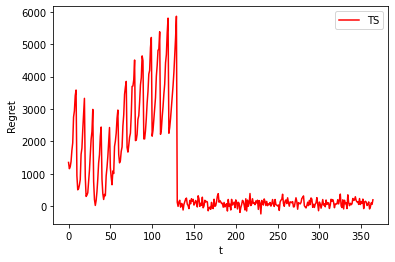

In [2]:
experiment6.showRegret()

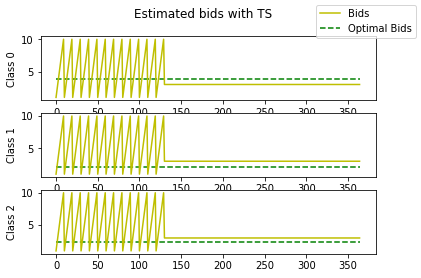

In [3]:
experiment6.show_bids_per_class()

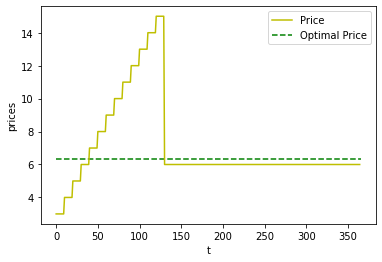

In [4]:
experiment6.show_prices()

### 7. Best joint strategy with known parameter, fixed bid, discrimination among customers and safety constraint in online enviroment
Solves the joint problem with user discrimination as in step 2, but with a different approach.

In [1]:
from experiments.experiment7 import Experiment7
experiment7 = Experiment7()
experiment7.run()

100%|██████████| 365/365 [00:01<00:00, 186.51it/s]


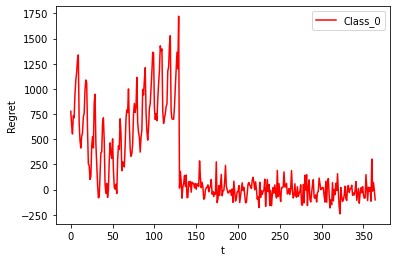

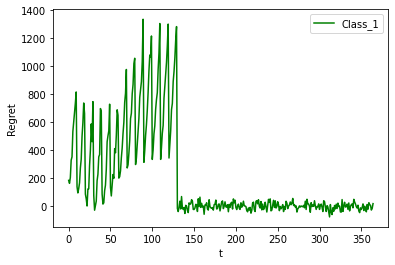

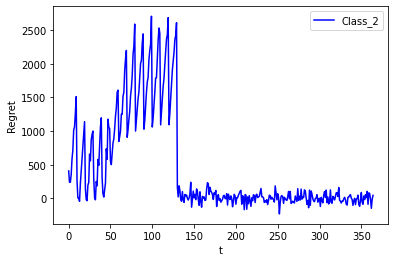

In [2]:
experiment7.showRegret()

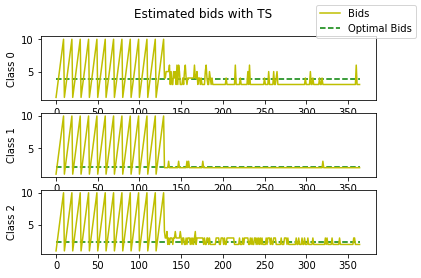

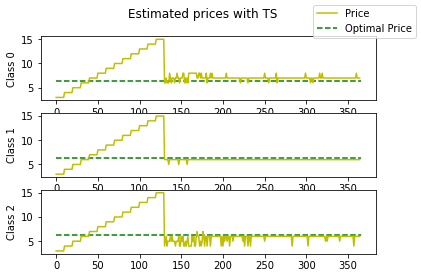

In [3]:

experiment7.show_bids_per_class()
experiment7.show_prices_per_class()